# Direction of Arrival estimation

In this notebook, we perform the estimation of the DOA of a sound source using pyroomacoustic library. The locations of microphones and the room dimensions are known. Several algorithms are implemented among them : SRP-PHAT, MUSIC, FRIDA

Import Necessary library

In [20]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt

True locations of the sound source

In [21]:
# Location of sources
azimuth = np.array([61., 270.]) / 180. * np.pi
distance = 2.  # meters

Constant and parameters for the algorithms

In [22]:
c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]

Room Settings

In [30]:
snr_db = 5.    # signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

# Create an anechoic room
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

Create the microphone array

In [24]:
center = room_dim/2

echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=37.5e-3)
echo = np.concatenate((echo, np.array(center, ndmin=2).T), axis=1)
aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

Create input audio as white gaussian noise 

In [25]:
# Add sources of 1 second duration
rng = np.random.RandomState(23)
duration_samples = int(fs)

for ang in azimuth:
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    source_signal = rng.randn(duration_samples)
    aroom.add_source(source_location, signal=source_signal)
    
# Run the simulation
aroom.simulate()

C-extension libroom unavailable. Falling back to pure python
C-extension libroom unavailable. Falling back to pure python


The DOA algorithms require an STFT input, which we will compute for overlapping frames for our 1 second duration signal.

In [26]:
X = np.array([pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T for signal in aroom.mic_array.signals])

In [33]:
algo_names = ['SRP', 'MUSIC', 'FRIDA', 'TOPS']
spatial_resp = dict()

# loop through algos
for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](echo, fs, nfft, c=c, num_src=2, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)

    # store spatial response
    if algo_name is 'FRIDA':
        spatial_resp[algo_name] = np.abs(doa._gen_dirty_img())
    else:
        spatial_resp[algo_name] = doa.grid.values
        
    # normalize   
    min_val = spatial_resp[algo_name].min()
    max_val = spatial_resp[algo_name].max()
    spatial_resp[algo_name] = (spatial_resp[algo_name] - min_val) / (max_val - min_val)

Plot estimated spectra and true location

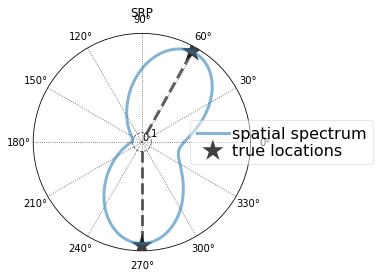

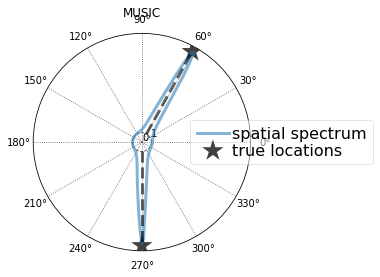

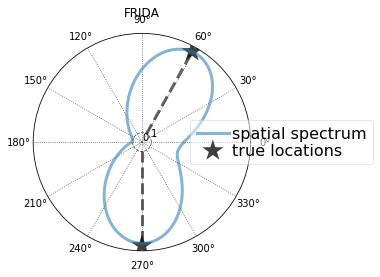

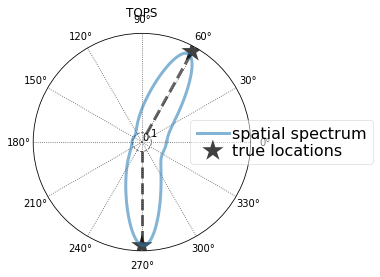

In [28]:
# plotting param
base = 1.
height = 10.
true_col = [0, 0, 0]

# loop through algos
phi_plt = doa.grid.azimuth
for algo_name in algo_names:
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    c_phi_plt = np.r_[phi_plt, phi_plt[0]]
    c_dirty_img = np.r_[spatial_resp[algo_name], spatial_resp[algo_name][0]]
    ax.plot(c_phi_plt, base + height * c_dirty_img, linewidth=3,
            alpha=0.55, linestyle='-',
            label="spatial spectrum")
    plt.title(algo_name)
    
    # plot true loc
    for angle in azimuth:
        ax.plot([angle, angle], [base, base + height], linewidth=3, linestyle='--',
            color=true_col, alpha=0.6)
    K = len(azimuth)
    ax.scatter(azimuth, base + height*np.ones(K), c=np.tile(true_col,
               (K, 1)), s=500, alpha=0.75, marker='*',
               linewidths=0,
               label='true locations')

    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, framealpha=0.5,
              scatterpoints=1, loc='center right', fontsize=16,
              ncol=1, bbox_to_anchor=(1.6, 0.5),
              handletextpad=.2, columnspacing=1.7, labelspacing=0.1)

    ax.set_xticks(np.linspace(0, 2 * np.pi, num=12, endpoint=False))
    ax.xaxis.set_label_coords(0.5, -0.11)
    ax.set_yticks(np.linspace(0, 1, 2))
    ax.xaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle=':')
    ax.yaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle='--')
    ax.set_ylim([0, 1.05 * (base + height)]);

plt.show()